<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/piecewise_quadratic_1d_opt_bins_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

torch.__version__

'2.9.0+cpu'

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dtype = torch.float32

Using device: cpu


This section defines the target function f.

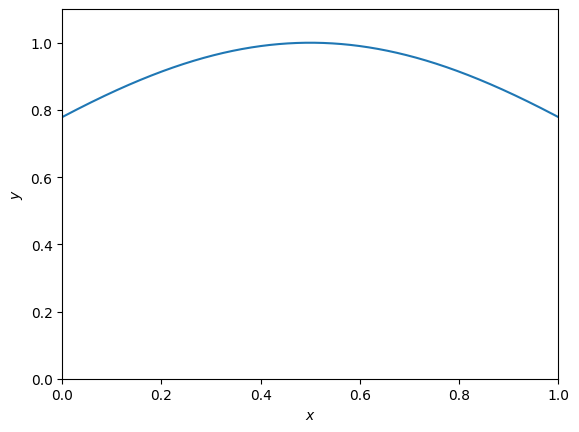

In [3]:
def f(x):
  return torch.exp(-((x-0.5)**2))

def plot_f(N):
  xs = torch.linspace(0, 1, N)
  f_evals = f(xs)

  fig = plt.figure()
  plt.plot(xs, f_evals)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.xlim(0, 1)
  plt.ylim(0, 1.1)
  plt.show()

  return fig

test = plot_f(1000)


REMEMBER you have now changed the definition of params to include the endpoints, to allow testing with the identity transformation.
D has been included to minimise changes from the 2D plus case but this means you must be careful with squeezing and unsqueezing.

In [4]:
### Example parameters for testing ###

D, n, K = 1, 10, 8

x = torch.rand(n)
params = torch.tensor([0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5])

This defines a function which, for a given set of parameters, returns the corresponding normalised pdf heights and bin areas

In [5]:
def preprocess_params_2(params, bins):

    """
    params: (D, K+1) unnormalised PDF heights
    bins: (D, K+1) bin edges
    returns:
      v:         (D, K+1) normalised PDF heights
      bin_areas: (D, K)   normalised bin areas
    """

    v = params
    v_left = v[:, :-1]
    v_right = v[:, 1:]
    bin_widths = bins[:, 1:] - bins[:, :-1]

    bin_areas = 0.5 * (v_left + v_right) * bin_widths
    total_area = bin_areas.sum(dim=1, keepdim=True)

    # normalise
    v = v / total_area
    bin_areas = bin_areas / total_area    #these should now sum to 1

    return v, bin_areas


In [37]:
#checking that the above function works correctly

#manual testing

test_params = torch.tensor([0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4]).unsqueeze(0)
test_bins = torch.tensor([0, 0.1, 0.3, 0.4, 0.45, 0.6, 0.7, 0.8, 1]).unsqueeze(0)

rand_params = torch.rand(D, K+1)
rand_bins = (torch.rand(D, K+1)).sort(dim=1).values

v = test_params
v_left = v[:, :-1]
v_right = v[:, 1:]
bin_widths = test_bins[:, 1:] - test_bins[:, :-1]

bin_areas = 0.5 * (v_left + v_right) * bin_widths
total_area = bin_areas.sum(dim=1, keepdim=True)

v = v / total_area
bin_areas = bin_areas / total_area
new_area = torch.sum(bin_areas, dim=1)

#direct function result
fn_v, fn_areas = preprocess_params_2(test_params, test_bins)

print('random params:', rand_params)
print('random bins:', rand_bins)


print('v_left:', v_left)
print('v_right:', v_right)
print('bin_widths:', bin_widths)
print('bin_areas:', bin_areas)
print('total_area:', total_area)
print('normalised params:', v)
print('fn output params:', fn_v)
print('normalised bin areas:', bin_areas)
print('fn output bin areas:', fn_areas)
print('new_area:', new_area)

#the function seems to work correctly - must be bucketize or cumulative area calcs in g

random params: tensor([[0.9874, 0.1100, 0.7079, 0.5972, 0.2827, 0.2612, 0.6366, 0.9353, 0.8296]])
random bins: tensor([[0.1054, 0.1703, 0.2113, 0.3318, 0.3510, 0.3791, 0.5577, 0.6519, 0.6712]])
v_left: tensor([[0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000]])
v_right: tensor([[0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000]])
bin_widths: tensor([[0.1000, 0.2000, 0.1000, 0.0500, 0.1500, 0.1000, 0.1000, 0.2000]])
bin_areas: tensor([[0.1000, 0.2000, 0.1000, 0.0500, 0.1500, 0.1000, 0.1000, 0.2000]])
total_area: tensor([[0.4500]])
normalised params: tensor([[0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889]])
fn output params: tensor([[0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889]])
normalised bin areas: tensor([[0.1000, 0.2000, 0.1000, 0.0500, 0.1500, 0.1000, 0.1000, 0.2000]])
fn output bin areas: tensor([[0.1000, 0.2000, 0.1000, 0.0500, 0.1500, 0.1000, 0.1000, 0.2000]])
new_area: tensor([1.])


This section defines the piecewise quadratic transform g which returns the cumulative distribution values for an input x corresponding to the given parameters.

In [6]:
def g(x, params, bins):

  '''
  PARAMS NOW INCLUDES ZEROS AND ONES TO SKIP CONCATENATING
  Piecewise quadratic transform with K bins, independent in different dimensions.
  This version allows variable bin widths.
  x.shape = (D, n); params.shape = (D, K+1) where D is dimensions, K is number of bins.
  bins.shape = (D, K+1)
  torch.bucketize only works here for random inputs - must sort for plotting
  x ---> y
  '''

  device = x.device
  dtype = x.dtype

  #bins
  D, n = x.shape
  K = params.size(1) - 1

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d)

  i_values = torch.stack(i_values, dim=0)   # shape (D, n)
  i_values_right = torch.clamp(i_values + 1, max=K)   #avoid out of range indexing

  v, bin_areas = preprocess_params_2(params, bins)

  #create row indices
  row_indices = torch.arange(D, device=device).unsqueeze(1)    #shape (D, 1)

  #bin edges
  x_left = bins[row_indices, i_values]    #shape (D, n)
  x_right = bins[row_indices, i_values_right]
  w_b = x_right - x_left   #shape (D, n); width of bin that each x is in

  #pdf heights
  v_left = v[row_indices, i_values]
  v_right = v[row_indices, i_values_right]
  w_v = v_right - v_left    #slope of pdf inside bin (linear)

  #transform to local coordinate alpha
  alpha = (x - x_left) / (w_b + 1e-12)    #avoid instability

  #cumulative area to left of x values
  cum_areas = torch.zeros(D, n, device=device, dtype=dtype)
  for d in range(D):
    for i in range(n):
      cum_areas[d, i] = torch.sum(bin_areas[d, :i_values[d, i]])

  c_left = cum_areas

  #compute quadratic mappings
  result = c_left + ((alpha**2/2) * w_v * w_b) + (alpha * v_left * w_b)
  return result   #quadratic in alpha with shape (D, n)


In [53]:
#debugging g

x_test = torch.rand(D, 20)

test_params = torch.tensor([0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4]).unsqueeze(0)
test_bins = torch.tensor([0, 0.1, 0.3, 0.4, 0.45, 0.6, 0.7, 0.8, 1]).unsqueeze(0)

rand_params = torch.rand(D, K+1)
rand_bins = (torch.rand(D, K-1)).sort(dim=1).values
zeros = torch.zeros((rand_bins.size(0), 1))
ones = torch.ones((rand_bins.size(0), 1))
rand_bins = torch.cat([zeros, rand_bins, ones], dim=1)

device = x_test.device
dtype = x_test.dtype

v, bin_areas = preprocess_params_2(rand_params, rand_bins)

i_values = []
for d in range(D):
  i_d = torch.bucketize(x_test[d], rand_bins[d], right=False) - 1
  i_values.append(i_d)

i_values = torch.stack(i_values, dim=0)
i_values_right = torch.clamp(i_values + 1, max=K)   #avoid out of bounds indexing

row_indices = torch.arange(D, device=device).unsqueeze(1)

#bin edges
x_left = rand_bins[row_indices, i_values]    #shape (D, n)

x_right = rand_bins[row_indices, i_values_right]

w_b = x_right - x_left   #shape (D, n)

#pdf heights
v_left = v[row_indices, i_values]
v_right = v[row_indices, i_values_right]
w_v = v_right - v_left    #slope of pdf inside bin (linear)

#transform to local coordinate alpha
alpha = (x_test - x_left) / (w_b + 1e-12)

#cumulative area to left of x values
cum_areas = torch.zeros(D, x_test.size(1), device=device, dtype=dtype)
for d in range(D):
  for i in range(x_test.size(1)):
    cum_areas[d, i] = torch.sum(bin_areas[d, :i_values[d, i]])

c_left = cum_areas

result = c_left + ((alpha**2/2) * w_v * w_b) + (alpha * v_left * w_b)


print('x_test:', x_test)
print('normalised params:', v)
print('bins:', rand_bins)
print('i_values:', i_values)
print('i_values_right:', i_values_right)
print('x_left:', x_left)
print('x_right:', x_right)
print('w_b:', w_b)
print('v_left:', v_left)
print('v_right:', v_right)
print('w_v:', w_v)
print('bin areas:', bin_areas)
print('cumulative area to left of x:', c_left)
print('g values:', result)

x_test: tensor([[0.0800, 0.0763, 0.4583, 0.9776, 0.9499, 0.2878, 0.7575, 0.5951, 0.9586,
         0.2386, 0.3168, 0.9790, 0.3299, 0.3760, 0.3551, 0.6613, 0.9400, 0.8385,
         0.0845, 0.3104]])
normalised params: tensor([[1.3053, 0.9998, 1.8886, 0.7992, 1.3915, 1.3031, 0.7365, 0.1322, 0.8677]])
bins: tensor([[0.0000, 0.0806, 0.1387, 0.3845, 0.4189, 0.6283, 0.6377, 0.9066, 1.0000]])
i_values: tensor([[0, 0, 4, 7, 7, 2, 6, 4, 7, 2, 2, 7, 2, 2, 2, 6, 7, 6, 1, 2]])
i_values_right: tensor([[1, 1, 5, 8, 8, 3, 7, 5, 8, 3, 3, 8, 3, 3, 3, 7, 8, 7, 2, 3]])
x_left: tensor([[0.0000, 0.0000, 0.4189, 0.9066, 0.9066, 0.1387, 0.6377, 0.4189, 0.9066,
         0.1387, 0.1387, 0.9066, 0.1387, 0.1387, 0.1387, 0.6377, 0.9066, 0.6377,
         0.0806, 0.1387]])
x_right: tensor([[0.0806, 0.0806, 0.6283, 1.0000, 1.0000, 0.3845, 0.9066, 0.6283, 1.0000,
         0.3845, 0.3845, 1.0000, 0.3845, 0.3845, 0.3845, 0.9066, 1.0000, 0.9066,
         0.1387, 0.3845]])
w_b: tensor([[0.0806, 0.0806, 0.2094, 0.0934, 0.0

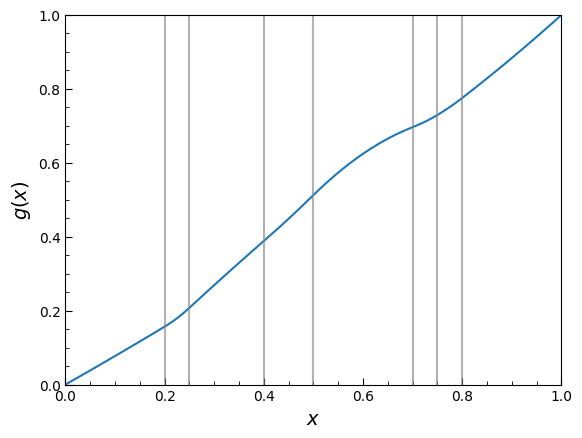

tensor(0.0013)
tensor(0.9992)


In [7]:
#test
K=8
x_test = torch.rand(D, 1000)
x_test = x_test.sort(dim=1).values

test_params = torch.tensor([0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4]).unsqueeze(0)
params = torch.rand(D, K+1)

bins = torch.tensor([0, 0.2, 0.25, 0.4, 0.5, 0.7, 0.75, 0.8, 1]).unsqueeze(0)
rand_bins = (torch.rand(D, K-1)).sort(dim=1).values
zeros = torch.zeros((rand_bins.size(0), 1))
ones = torch.ones((rand_bins.size(0), 1))
rand_bins = torch.cat([zeros, rand_bins, ones], dim=1)

g_test = g(x_test, params, bins)


fig, ax = plt.subplots()
ax.plot(x_test.squeeze(), g_test.squeeze())   #data

for b in bins.squeeze()[1:-1]:
  ax.axvline(b.item(), color="gray", alpha=0.6)   #bin edges


ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$g(x)$", fontsize=14)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
plt.show()


print(g_test.squeeze()[0])
print(g_test.squeeze()[-1])

Debugging h (for reference if required)

In [ ]:
### experimenting with h ###

cdf_values = g_test
v, bin_areas = preprocess_params(params.unsqueeze(0)) # Unsqueeze params to make it (D, K+1)

#bins
bins = torch.linspace(0, 1, K+1).repeat(D, 1)


#v_left_for_areas = v[:, :-1]
#v_right_for_areas = v[:, 1:]
#bin_widths = bins[:, 1:] - bins[:, :-1]
#bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths #trapezium rule
c_edges = torch.zeros((D, K+1))   #cdf starts at 0
c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

j_values = []
for d in range(D):
  j_d = torch.bucketize(cdf_values[d], c_edges[d], right=False) - 1
  j_values.append(j_d)

j_values = torch.stack(j_values, dim=0)   #these are correct so far

row_indices = torch.arange(D).unsqueeze(1)

#compute the edge positions
x_left = bins[row_indices, j_values]
x_right = bins[row_indices, j_values+1]
w_b = x_right - x_left    #bin width(s)

c_left = c_edges[row_indices, j_values]

v_left = v[row_indices, j_values]
v_right = v[row_indices, j_values+1]
w_v = v_right - v_left    #vertex differences

#solve quadratic to obtain alpha values

# coefficients
a = 0.5 * w_v * w_b
b = v_left * w_b
c = c_left - cdf_values

# linear vs quadratic bins
is_linear = torch.abs(w_v) < 1e-12

alpha = torch.empty_like(cdf_values)

# linear case
alpha[is_linear] = (cdf_values[is_linear] - c_left[is_linear]) / (
    v_left[is_linear] * w_b[is_linear]
)

# quadratic case
disc = torch.clamp(b*b - 4*a*c, min=0.0)
alpha[~is_linear] = (
    -b[~is_linear] + torch.sqrt(disc[~is_linear])
) / (2*a[~is_linear])

#obtain x values

x = x_left + (w_b*alpha)
jac = 1 / (v_left + w_v * alpha)
#jac_det = jac.prod(dim=0)

print('cdf_values:', cdf_values)
print('c_edges:', c_edges)
print('j_values:', j_values)
print('x_left:', x_left)
print('x_right:', x_right)
print('w_b:', w_b)
print('c_left:', c_left)
print('v:', v)
print('v_left:', v_left)
print('v_right:', v_right)
print('w_v:', w_v)
print('alphas:', alpha)
print('x:', x)
print('Jacobians:', jac)
print('h:', f(x) * jac)

ValueError: too many values to unpack (expected 2)

This section defines the transformed function h using the change of variables formula to preserve the integral value.

In [8]:
def h(y, params, bins):

  '''
  Resulting function when the piecewise warp is applied, in accordance with change of variables formula.
  Integral should be preserved.
  Non-uniform bins are permitted.
  '''

  device = y.device
  dtype = y.dtype

  D, n = y.shape
  K = params.size(1) -1

  v, bin_areas = preprocess_params_2(params, bins)

  #cumulative areas

  c_edges = torch.zeros((D, K+1), device=device, dtype=dtype)   #cdf starts at 0
  c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], c_edges[d], right=False) - 1
    j_values.append(j_d)

  j_values = torch.stack(j_values, dim=0)
  j_values_right = torch.clamp(j_values + 1, max=K)   #avoid out of bounds indexing

  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edge positions
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values_right]
  w_b = x_right - x_left    #bin width(s)

  c_left = c_edges[row_indices, j_values]

  v_left = v[row_indices, j_values]
  v_right = v[row_indices, j_values_right]
  w_v = v_right - v_left    #vertex differences

  #solve quadratic to obtain alpha values

  # coefficients
  a = 0.5 * w_v * w_b
  b = v_left * w_b
  c = c_left - y

  # linear vs quadratic bins
  is_linear = torch.abs(w_v) < 1e-12

  alpha = torch.empty_like(y, device=device, dtype=dtype)

  # linear case
  alpha[is_linear] = (y[is_linear] - c_left[is_linear]) / (
      v_left[is_linear] * w_b[is_linear]
  )

  # quadratic case
  disc = torch.clamp(b*b - 4*a*c, min=0.0)
  alpha[~is_linear] = (
      -b[~is_linear] + torch.sqrt(disc[~is_linear])
  ) / (2*a[~is_linear])

  #jacobians

  jac = 1 / (v_left + (w_v*alpha))

  #obtain x values
  x = x_left + (w_b*alpha)

  return f(x) * jac


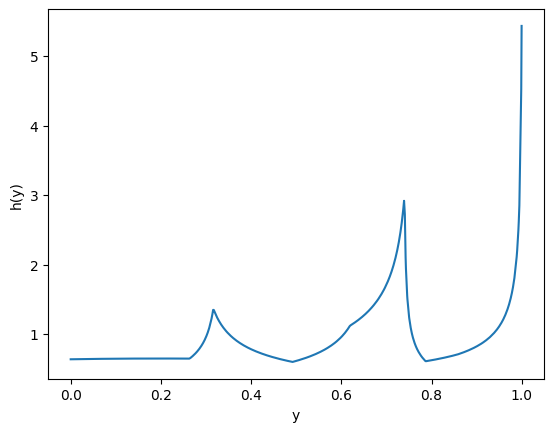

In [9]:
#test plot of h

y_test = torch.rand(1000)
y_test_sorted = torch.sort(y_test).values

params = torch.rand(9)
bins = torch.tensor([0, 0.2, 0.25, 0.4, 0.5, 0.7, 0.75, 0.8, 1]).unsqueeze(0)

rand_bins = (torch.rand(D, K-1)).sort(dim=1).values
zeros = torch.zeros((rand_bins.size(0), 1))
ones = torch.ones((rand_bins.size(0), 1))
rand_bins = torch.cat([zeros, rand_bins, ones], dim=1)

h_test = h(y_test_sorted.unsqueeze(0), params.unsqueeze(0), bins)
#print(h_test)
plt.plot(y_test_sorted, h_test.squeeze(0))
plt.xlabel('y')
plt.ylabel('h(y)')
plt.show()

Checking integral preservation and variance

In [10]:
#check integral is preserved using (naive) MC

###REFERENCE VALUE: 0.922562###
N = 1000000
#torch.manual_seed(42)
test_params = params
test_bins = bins

def MC_F(N):
  x = torch.rand(N)
  f_evals = f(x)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params, bins):
  y = torch.rand(N)
  h_evals = h(y.unsqueeze(0), params, bins) # Unsqueezing y to (1, N) to match h's expected (D, n) input
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H

F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} \u00b1 {alpha_F}')

H_est, alpha_H = MC_H(N, params.unsqueeze(0), test_bins)
print(f'H estimate = {H_est} \u00b1 {alpha_H}')

F estimate = 0.9225692749023438 ± 6.710299931000918e-05
H estimate = 0.922102689743042 ± 0.00046368467155843973


In [11]:
#check that variances are different in general
test_set = torch.rand(D, N)

f_var = torch.var(f(test_set))

h_for_var = h(test_set, test_params.unsqueeze(0), test_bins) # Unsqueeze test_params to make it (D, K+1)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0045)
H variance: tensor(0.2154)


Defining the training loop for optimisation of parameters in order to minimise variance

In [19]:
#function enforcing positivity and enabling unconstrained parameters
#can also use this for the bin widths

def positive_params(params):
  return torch.nn.functional.softplus(params) + 1e-9

print(positive_params(torch.zeros(D, K+1)))


#softmax testing so that the bin widths sum to 1

def softmax(params):
  return torch.nn.functional.softmax(params, dim=1)

s = softmax(torch.rand(D, 10))

print(s)
print(torch.sum(s, dim=1))

def widths_to_edges(widths):

  int_edges = torch.cumsum(widths, dim=1)
  edges = torch.cat([int_edges.new_zeros((D, 1)), int_edges], dim=1)
  return edges

tensor([[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931]])
tensor([[0.0657, 0.1110, 0.1537, 0.0636, 0.0659, 0.1288, 0.0909, 0.1179, 0.0843,
         0.1182]])
tensor([1.0000])


In [78]:
#optimisation via training loop - loss function is the variance

def train_loop(x, K, epochs, lr, device, ticker):
  '''
  x.shape = (D, n); K bins, D dimensions
  '''
  if device is None:
    device = x.device

  D = x.size(0)
  u_params = torch.rand((D, K+1), device=device, requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
  loss_values = torch.zeros(epochs, device=device)
  max_norm = 1

  for epoch in range(epochs):
    params = positive_params(u_params)
    g_eval = g(x, params)
    h_eval = h(g_eval, params)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    total_norm = torch.nn.utils.clip_grad_norm_(u_params, max_norm)

    optimiser.step()

    before_lr = optimiser.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimiser.param_groups[0]["lr"]
    if epoch % 10 == 0:
      print("Epoch %d: lr %.9f -> %.9f" % (epoch, before_lr, after_lr))
      print(f"Grad norm (pre-clip): {total_norm:.8f}")

    if ticker == True:
      if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

  final_loss = loss

  return final_loss, loss_values, positive_params(u_params)


### use this one below  ###

def train_loop_improved(x, K, epochs, lr, device, ticker, early_stopping):
    '''
    x.shape = (D, n); K bins, D dimensions
    Early stopping parameters not finalised
    '''
    if device is None:
        device = x.device

    x = x.to(device=device, dtype=dtype)    #float64 precision can be added here

    D = x.size(0)

    #pdf heights
    u_params = torch.rand((D, K+1), device=device, dtype=dtype, requires_grad=True)

    #bin widths
    raw_widths = torch.rand((D, K), device=device, dtype=dtype, requires_grad=True)

    optimiser = torch.optim.Adam([{"params": u_params, "lr": lr}, {"params": raw_widths, "lr": lr * 0.1}])    #decoupled learning rates

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.992)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=epochs, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.8, patience=10, threshold=1e-9, min_lr=1e-6)


    loss_values = torch.zeros(epochs, device=device, dtype=dtype)

    # early stopping parameters
    tol = 1e-5          # tighter tolerance for float64
    patience = 4        #number of consecutive small changes allowed
    eps = 1e-10
    prev_loss = None
    small_change_count = 0
    grad_tol = 1e-6

    for epoch in range(epochs):
        params = positive_params(u_params)
        widths = softmax(raw_widths)
        bin_edges = torch.cumsum(widths, dim=1)
        bin_edges = torch.cat([bin_edges.new_zeros((D, 1)), bin_edges], dim=1)

        g_eval = g(x, params, bin_edges)
        h_eval = h(g_eval, params, bin_edges)

        loss = torch.var(h_eval)

        loss_values[epoch] = loss.detach()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        before_lr = optimiser.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimiser.param_groups[0]["lr"]

        grad_norm = (u_params.grad.norm().item() if u_params.grad is not None else 0.0)

        #if epoch % 10 == 0:
          #print("Epoch %d: lr %.9f -> %.9f" % (epoch, before_lr, after_lr))
          #print(f"Grad norm: {grad_norm:.8e}")

        if ticker and epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.8e}")

        # convergence-based early stopping
        if early_stopping == True:

          loss_val = loss.item()
          if prev_loss is not None:
              frac_change = abs(loss_val - prev_loss) / max(abs(prev_loss), eps)

              if frac_change < tol and grad_norm < grad_tol:
                small_change_count += 1
              else:
                small_change_count = 0

              if small_change_count >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

          prev_loss = loss_val
        # ----------------------------------------

    final_loss = loss.detach()
    final_params = positive_params(u_params).detach()
    final_widths = softmax(raw_widths).detach()

    return final_loss, loss_values[:epoch + 1], final_params, final_widths


In [77]:
train_x = torch.rand(D, 1000, device='cpu', dtype=dtype)
final_loss, loss_values, opt_params, opt_widths = train_loop_improved(train_x, K=32, epochs=300, lr=0.03, device=device, ticker=True, early_stopping=True)

opt_bins = widths_to_edges(opt_widths)


print("Final loss:", final_loss.item())
print("Optimised parameters:", opt_params)
print("Optimised bin positions:", opt_bins)

Epoch: 0 | Loss: 3.21059637e-02
Epoch: 10 | Loss: 4.42124764e-03
Epoch: 20 | Loss: 8.05631687e-04
Epoch: 30 | Loss: 4.26640763e-04
Epoch: 40 | Loss: 2.28349702e-04
Epoch: 50 | Loss: 3.51851158e-05
Epoch: 60 | Loss: 1.79201670e-05
Epoch: 70 | Loss: 9.47674107e-06
Epoch: 80 | Loss: 2.08532765e-06
Epoch: 90 | Loss: 7.48729008e-07
Epoch: 100 | Loss: 2.91089805e-07
Epoch: 110 | Loss: 1.14640130e-07
Epoch: 120 | Loss: 4.43349819e-08
Epoch: 130 | Loss: 2.00409538e-08
Epoch: 140 | Loss: 1.16164145e-08
Epoch: 150 | Loss: 9.71444525e-09
Epoch: 160 | Loss: 8.73615225e-09
Epoch: 170 | Loss: 8.26345659e-09
Epoch: 180 | Loss: 8.17074941e-09
Epoch: 190 | Loss: 8.16047319e-09
Epoch: 200 | Loss: 8.14751999e-09
Epoch: 210 | Loss: 8.13938339e-09
Epoch: 220 | Loss: 8.13761059e-09
Epoch: 230 | Loss: 8.13716650e-09
Epoch: 240 | Loss: 8.13647993e-09
Epoch: 250 | Loss: 8.13683876e-09
Epoch: 260 | Loss: 8.13670464e-09
Epoch: 270 | Loss: 8.13667533e-09
Epoch: 280 | Loss: 8.13664514e-09
Epoch: 290 | Loss: 8.1365

Making a plot comparing the original function f to the transformed function h with optimised parameters.  

tensor(8.9189e-09)


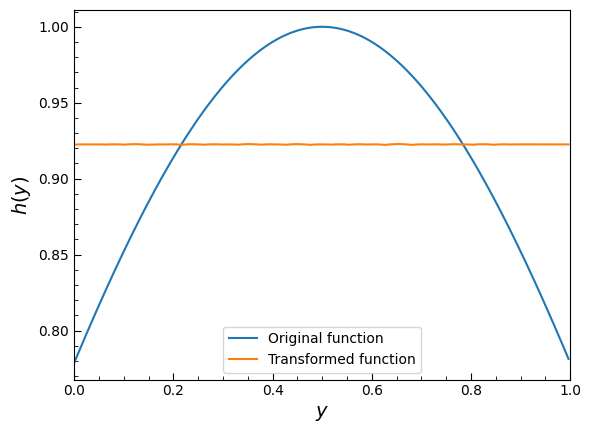

In [79]:
#plot of h with optimised parameters, comparing to original function

y_plot = torch.sort(torch.rand(1000)).values
h_test = h(y_plot.unsqueeze(0), opt_params, opt_bins)
print(torch.var(h_test))

fig, ax = plt.subplots()

ax.plot(y_plot, f(y_plot), label='Original function')
ax.plot(y_plot, h_test.squeeze(0), label='Transformed function')    #data

ax.set_xlabel("$y$", fontsize=14)
ax.set_ylabel("$h(y)$", fontsize=14)
ax.set_xlim(0.0, 1.0)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

plt.legend()

plt.show()



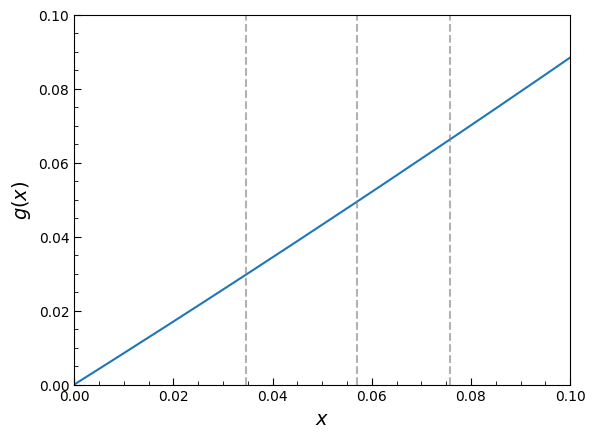

In [82]:
#plot of the transform with optimised parameters

x_plot = torch.sort(torch.rand(1000)).values
g_plot = g(x_plot.unsqueeze(0), opt_params, opt_bins)

fig, ax = plt.subplots()

ax.plot(x_plot, g_plot.squeeze(0))

for b in opt_bins.squeeze()[1:-1]:
  ax.axvline(b.item(), color="gray", linestyle='--', alpha=0.6)   #bin edges

ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$g(x)$", fontsize=14)
ax.set_xlim(0.0, 0.1)
ax.set_ylim(0.0, 0.1)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

plt.show()

This section is purely for visualisation/analysis tools - variation of loss with epoch, final loss vs number of bins, loss vs epoch for different learning rates, histogram of function evaluations for variance estimates.

In [81]:
device = train_x.device
dtype = train_x.dtype
epochs = 250
K_s = [2, 4, 8, 16, 32, 64]

results = {}  # K -> loss tensor

for K in K_s:
    _, losses, _, _ = train_loop_improved(
        train_x,
        K,
        epochs,
        lr=0.03,
        device=device,
        ticker=False,
        early_stopping=True
    )
    results[K] = losses.detach().cpu()


Early stopping at epoch 208
Early stopping at epoch 210


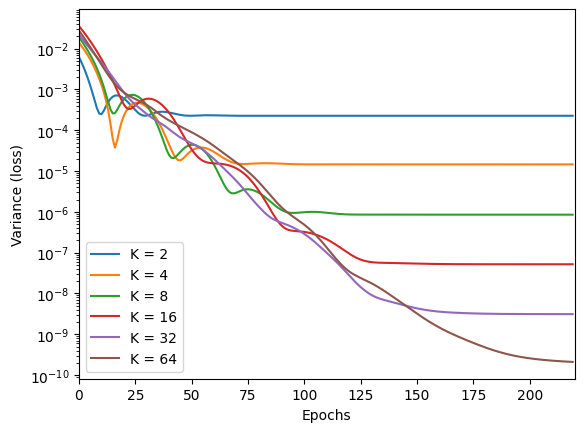

In [ ]:
#plotting for no early stopping
epochs_plot = torch.arange(epochs, device='cpu')
plt.figure()
for i in range(len(K_s)):
  plt.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=f'K = {K_s[i]}')

plt.xlabel('Epochs')
plt.ylabel('Variance (loss)')
plt.legend()
plt.xlim(0, 220)
plt.yscale('log')
plt.show()

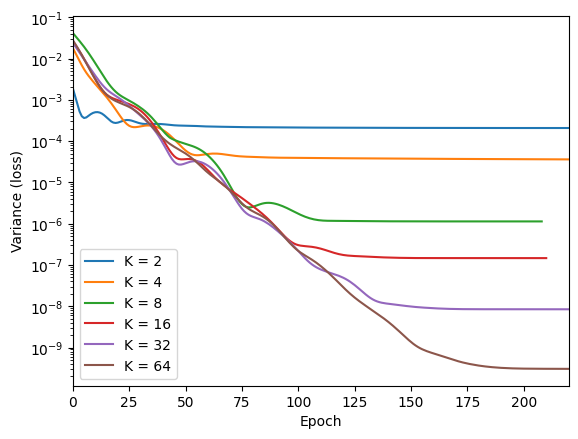

In [83]:
#plotting for early stopping enabled

plt.figure()

for K, losses in results.items():
    epochs_plot = torch.arange(len(losses))
    plt.plot(epochs_plot, losses.numpy(), label=f"K = {K}")

plt.xlabel("Epoch")
plt.ylabel("Variance (loss)")
plt.yscale("log")
plt.xlim(0, 220)
plt.legend()
plt.show()


In [ ]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks))
i=0

for K in Ks:
  if K >= 60:
    epochs = 230
  else:
    epochs = 200
  result = train_loop(train_x, K, epochs=epochs, lr=0.03, device=device, ticker=False)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

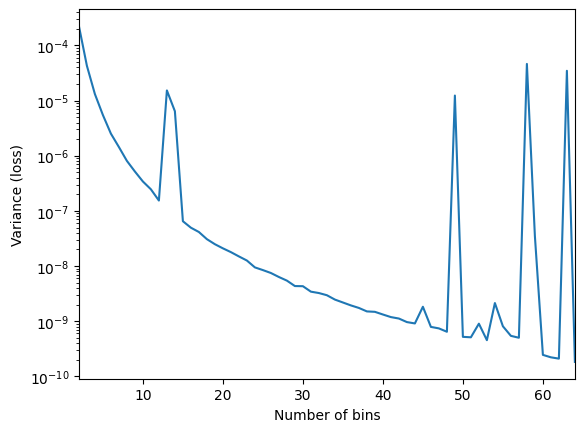

tensor([2.2566e-04, 4.2774e-05, 1.3136e-05, 5.4786e-06, 2.5172e-06, 1.4397e-06,
        8.0725e-07, 5.1802e-07, 3.4145e-07, 2.4652e-07, 1.5416e-07, 1.5279e-05,
        6.4114e-06, 6.5012e-08, 4.9647e-08, 4.1454e-08, 3.0759e-08, 2.4915e-08,
        2.0972e-08, 1.7900e-08, 1.4968e-08, 1.2604e-08, 9.4677e-09, 8.4584e-09,
        7.4909e-09, 6.3382e-09, 5.4494e-09, 4.3447e-09, 4.3178e-09, 3.4378e-09,
        3.2447e-09, 2.9625e-09, 2.4702e-09, 2.1877e-09, 1.9368e-09, 1.7422e-09,
        1.5073e-09, 1.4814e-09, 1.3250e-09, 1.1894e-09, 1.1195e-09, 9.6565e-10,
        9.1234e-10, 1.8311e-09, 7.8971e-10, 7.4188e-10, 6.4488e-10, 1.2339e-05,
        5.2150e-10, 5.1164e-10, 9.0314e-10, 4.5390e-10, 2.1365e-09, 8.1118e-10,
        5.4348e-10, 5.0210e-10, 4.6182e-05, 3.4966e-08, 2.4561e-10, 2.2181e-10,
        2.1003e-10, 3.4672e-05, 1.8306e-10], grad_fn=<CopySlices>)


In [ ]:
#plotting

plt.figure()
plt.plot(Ks, vars.detach().cpu().numpy()) # Detach and convert to numpy for plotting
plt.xlabel('Number of bins')
plt.ylabel('Variance (loss)')
plt.yscale('log')
plt.xlim(2, 64)
plt.show()
print(vars)   #check accuracy